In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothicCoding')


from skimage.metrics import structural_similarity as compare_ssim
import imutils

from changeDetector import *

In [2]:
def read_img(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, gray


def plot_two(shape, imgs, title=None):
    fig, axes = plt.subplots(*shape, figsize=(20, 8))
    for i, img in enumerate(imgs):
        axes[i].imshow(img, 'gray')
        if title:
            axes[i].set_title(title.split('&')[i], size=20, weight='semibold')
    plt.tight_layout()
    plt.show()


def plot_diff(path1, path2, shape=(1,2)):
    img1, gray1 = read_img(path1)
    img2, gray2 = read_img(path2)
    coors = get_diff(img1, img2, gray1, gray2)
    for coor in coors:
        (x, y, w, h) = coor
        cv2.rectangle(img1, (x, y), (x + w, y + h), (0, 0, 255), 10)
        cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 10)

    plot_two(shape, [img1, img2], title=f'{path1} & {path2}')


def plot_all(path1, path2):
    img1, gray1 = read_img(path1)
    img2, gray2 = read_img(path2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    axes[0].imshow(img1)
    axes[0].set_title(f'{path1}', size=20)

    axes[1].imshow(img2)
    axes[1].set_title(f'{path2}', size=20)
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(14, 10))

    #compare
    (score, diff) = compare_ssim(gray1, gray2, full=True)
    diff = np.where(diff < 0.2, 0, diff)
    diff = (diff * 255).astype("uint8")
    axes[0].imshow(diff, 'gray')
    axes[0].set_title('diff', size=20)

    #thresh
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    axes[1].imshow(thresh, 'gray')
    axes[1].set_title('thresh', size=20)

    #opening
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=12)
    axes[2].imshow(opening, 'gray')
    axes[2].set_title('opening', size=20)
    plt.show()

    # bbox
    cnts = cv2.findContours(opening.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    for c in cnts:
        # compute the bounding box of the contour and then draw the
        # bounding box on both input images to represent where the two
        # images differ
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(img1, (x, y), (x + w, y + h), (0, 0, 255), 20)
        cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 20)
        print(f'({x}, {y}, {w}, {h}): {diff[y:y+h, x:x+w].mean()}')

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    axes[0].imshow(img1)
    axes[0].set_title(f'{path1}', size=20)

    axes[1].imshow(img2)
    axes[1].set_title(f'{path2}', size=20)
    plt.show()

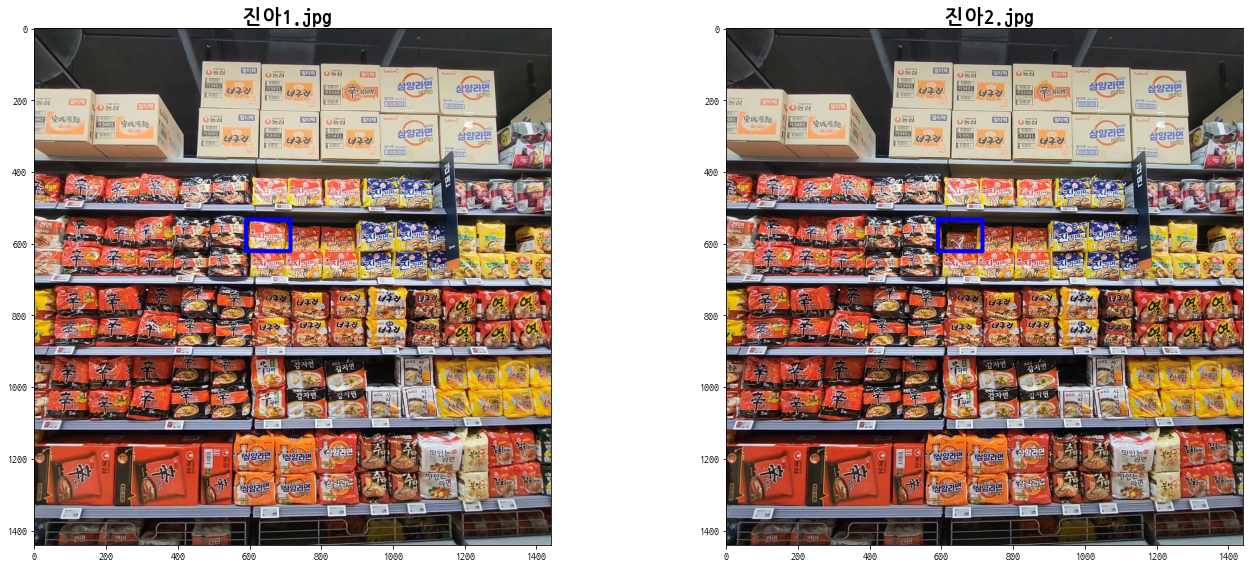

In [3]:
plot_diff('진아1.jpg', '진아2.jpg')